In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [1]:
!pip install dill


[notice] A new release of pip available: 22.3 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator ,load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.losses import SparseCategoricalCrossentropy
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import os
import numpy as np
from tensorflow.keras.regularizers import l2 , l1
from tensorflow.keras.applications import VGG16 , VGG19 , ResNet50 ,EfficientNetB0
import dill
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from transformers import ViTFeatureExtractor, ViTForImageClassification
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Lambda
import tensorflow.keras.backend as K
from keras import layers, models

In [3]:
# Update data directory and categories
data_dir = '../Acne Data/Severity_Dataset/Severity_Dataset'
categories = ['Level 0', 'Level 1', 'Level 2', 'Level 3']
img_height = 224
img_width = 224
batch_size = 32

In [4]:
class_counts = {}

for category in categories:
    class_path = os.path.join(data_dir, category)
    class_counts[category] = len(os.listdir(class_path))

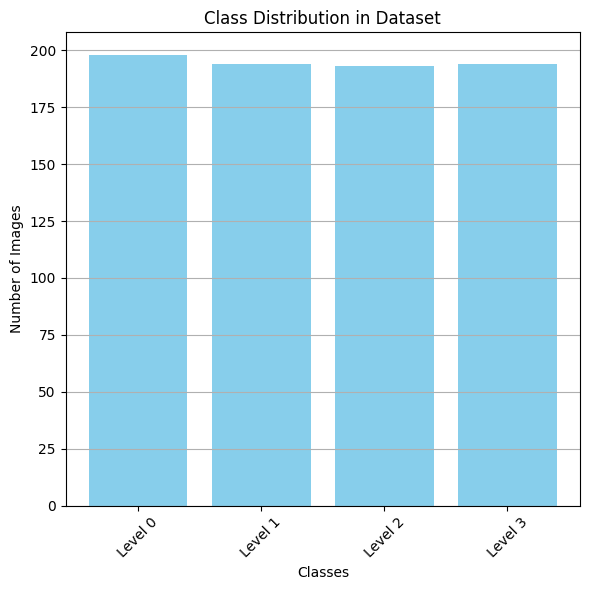

In [5]:
plt.figure(figsize=(6, 6))
plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')
plt.title('Class Distribution in Dataset')
plt.xlabel('Classes')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [6]:
# Function to load images and labels (similar to your acne detection model)
def load_data(data_dir, categories):
  images = []
  labels = []
  for category in categories:
    category_path = os.path.join(data_dir, category)
    for img_name in os.listdir(category_path):
      img_path = os.path.join(category_path, img_name)
      img = cv2.imread(img_path)
      img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB
      img = cv2.resize(img, (224, 224))  # Resize image to uniform size
      images.append(img)
      labels.append(categories.index(category))  # One-hot encoding
  return np.array(images), np.array(labels)

In [7]:
# Load images and labels
images, labels = load_data(data_dir, categories)

In [8]:
# Normalize images
images = images / 255.0

In [9]:
# Split dataset into training and validation sets (80% train, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=42)  # Consistent random state


In [10]:
def augment_function(image):
    # Color-based augmentations
    image = tf.image.random_brightness(image, max_delta=0.2)  # Brightness
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)  # Contrast
    image = tf.image.random_saturation(image, lower=0.8, upper=1.2)  # Saturation
    image = tf.image.random_hue(image, max_delta=0.1)  # Hue

    image = tf.image.random_crop(image, size=[int(img_height * 0.8), int(img_width * 0.8), 3])
    image = tf.image.resize(image, [img_height, img_width])

    return image

In [11]:
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    preprocessing_function=augment_function  # Apply the augmentation function
)

In [12]:
# Fit data augmentation on training data
datagen.fit(X_train)

In [13]:
# Create TensorFlow Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)


In [14]:
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val_dataset = val_dataset.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.035932343..1.0863574].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.13929276..1.2036943].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.13809536..0.7470717].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.11569412..1.183757].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.19143315..1.0173783].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.18349412..1.0516175].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.11647

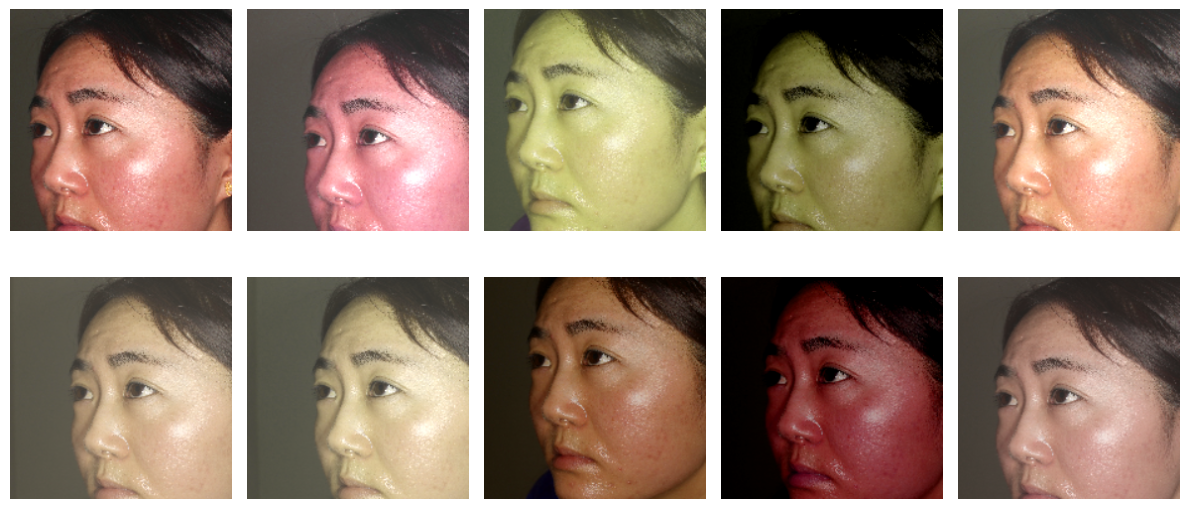

In [15]:
# Get the first batch from the prefetched dataset
data_batch = next(iter(train_dataset))
images, _ = data_batch  # Separate images and labels

# Take the first image from the batch
img = images[0]

# Visualize Augmentations
plt.figure(figsize=(12, 6))
for i in range(10):
  augmented_img = augment_function(img.numpy())  # Apply augmentations (convert to NumPy)
  plt.subplot(2, 5, i + 1)
  plt.imshow(augmented_img)
  plt.axis('off')
plt.tight_layout()
plt.show()

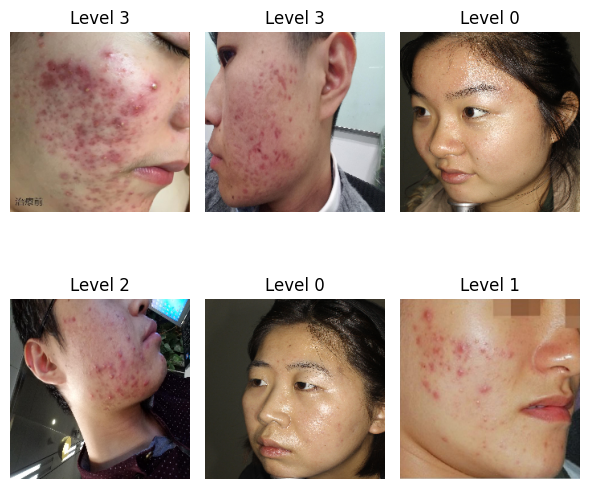

In [16]:
# Get class names from the labels
class_names = categories  # Use the categories list defined earlier

# Get a batch of images and labels from the training dataset
images, labels = next(iter(train_dataset))  # Use `iter` to get the next batch

# Plot the images
plt.figure(figsize=(6, 6))

for i in range(6):
    ax = plt.subplot(2, 3, i + 1)  # Adjust subplot layout as needed
    plt.imshow(images[i])  # Display the image
    plt.title(class_names[labels[i].numpy()])  # Get the corresponding class name
    plt.axis("off")

plt.tight_layout()
plt.show()

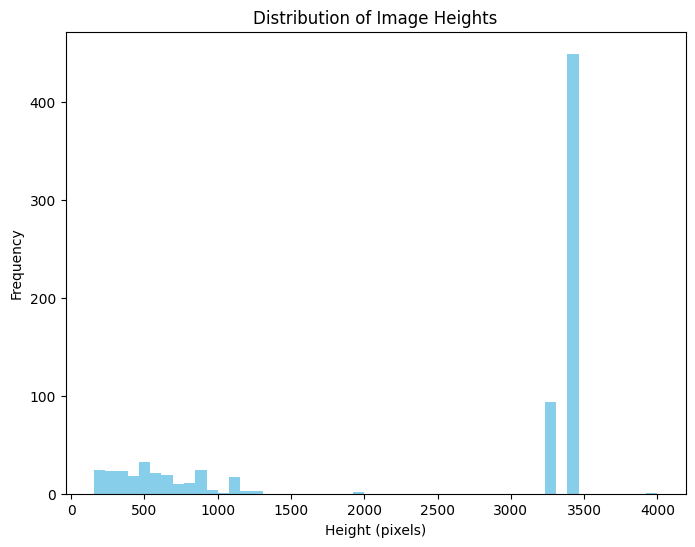

In [17]:
# --- Plotting the graphs ---

# 1. Distribution of Image Heights
heights = []
for class_name in os.listdir(data_dir):
    class_path = os.path.join(data_dir, class_name)
    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)
        img = cv2.imread(img_path)
        heights.append(img.shape[0])

plt.figure(figsize=(8, 6))
plt.hist(heights, bins=50, color='skyblue')
plt.title('Distribution of Image Heights')
plt.xlabel('Height (pixels)')
plt.ylabel('Frequency')
plt.show()

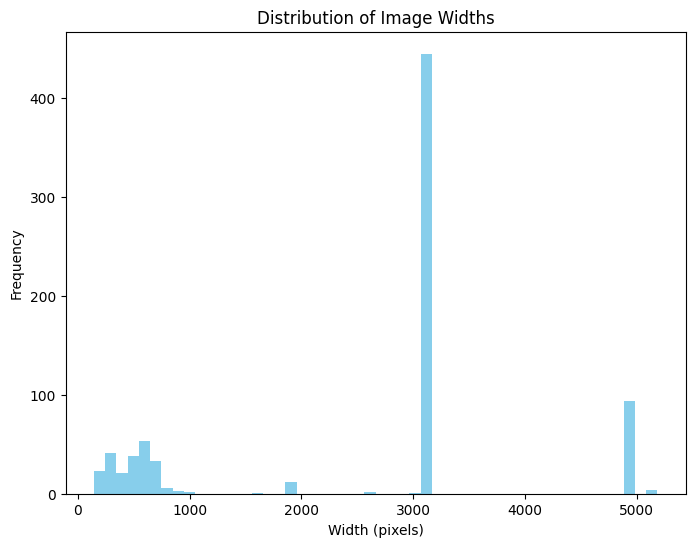

In [18]:
# 2. Distribution of Image Widths
widths = []
for class_name in os.listdir(data_dir):
    class_path = os.path.join(data_dir, class_name)
    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)
        img = cv2.imread(img_path)
        widths.append(img.shape[1])

plt.figure(figsize=(8, 6))
plt.hist(widths, bins=50, color='skyblue')
plt.title('Distribution of Image Widths')
plt.xlabel('Width (pixels)')
plt.ylabel('Frequency')
plt.show()

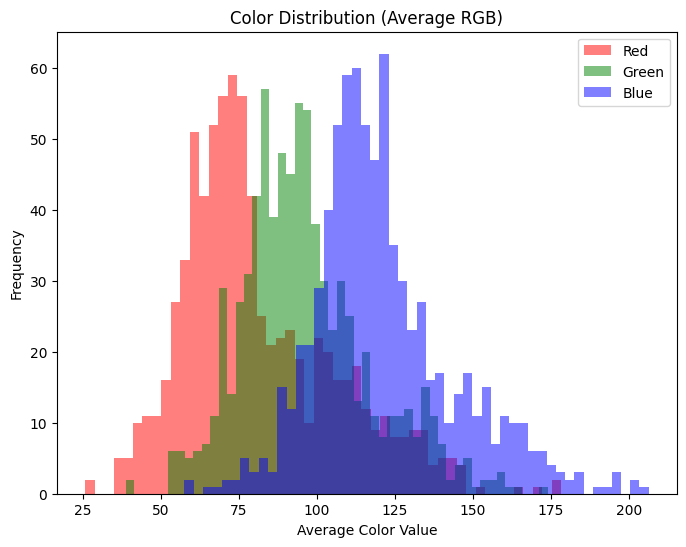

In [19]:
# 3. Color Distribution (using average RGB values)
avg_r = []
avg_g = []
avg_b = []
for class_name in os.listdir(data_dir):
    class_path = os.path.join(data_dir, class_name)
    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)
        img = cv2.imread(img_path)
        avg_r.append(np.mean(img[:, :, 0]))
        avg_g.append(np.mean(img[:, :, 1]))
        avg_b.append(np.mean(img[:, :, 2]))

plt.figure(figsize=(8, 6))
plt.hist(avg_r, bins=50, color='red', alpha=0.5, label='Red')
plt.hist(avg_g, bins=50, color='green', alpha=0.5, label='Green')
plt.hist(avg_b, bins=50, color='blue', alpha=0.5, label='Blue')
plt.title('Color Distribution (Average RGB)')
plt.xlabel('Average Color Value')
plt.ylabel('Frequency')
plt.legend()
plt.show()

#ViT (Vision Transformaers)

In [38]:
import tensorflow as tf
from transformers import ViTFeatureExtractor, ViTForImageClassification
from sklearn.model_selection import train_test_split
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from transformers import ViTForImageClassification, ViTFeatureExtractor
from torch.utils.data import DataLoader
import torch
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm  # Import tqdm for the progress bar

In [21]:
import torch
print(torch.__version__)

2.5.1+cpu


In [23]:
# Initialize ViT feature extractor and model
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224')


In [24]:
model = ViTForImageClassification.from_pretrained(
    'google/vit-base-patch16-224',
    num_labels=len(categories),
    ignore_mismatched_sizes=True
)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([4]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([4, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [26]:
# Prepare dataset for ViT
def preprocess_images(images):
    return np.array([feature_extractor(image, return_tensors='np')['pixel_values'][0] for image in images])

In [27]:
# Preprocess the training and validation datasets
X_train_vit = preprocess_images(X_train)
X_val_vit = preprocess_images(X_val)

It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.


In [32]:
# Convert the training and validation datasets to PyTorch tensors
train_dataset_tensor = TensorDataset(torch.tensor(X_train_vit), torch.tensor(y_train))
val_dataset_tensor = TensorDataset(torch.tensor(X_val_vit), torch.tensor(y_val))

In [33]:
# Create DataLoader for training and validation
train_loader = DataLoader(train_dataset_tensor, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset_tensor, batch_size=batch_size, shuffle=False)

In [34]:
# Check if GPU is available and use it
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_fe

In [49]:
# Define the optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
loss_fn = torch.nn.CrossEntropyLoss()

In [50]:
# Lists to store the loss and accuracy values
train_losses = []
val_losses = []
val_accuracies = []
train_accuracies=[]

In [ ]:
# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    total_loss = 0
    correct = 0

    for step, batch in enumerate(tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}', unit='step')):
        optimizer.zero_grad()  # Clear gradients
        inputs, labels = batch
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = model(inputs).logits
        loss = loss_fn(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = torch.argmax(outputs, dim=1)
        correct += (preds == labels).sum().item()

    avg_loss = total_loss / len(train_loader)
    train_accuracy = correct / len(train_loader.dataset)
    train_losses.append(avg_loss)
    train_accuracies.append(train_accuracy)

    # Validation step
    model.eval()  # Set the model to evaluation mode
    val_loss = 0
    correct = 0
    with torch.no_grad():
        for batch in val_loader:
            inputs, labels = batch
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs).logits
            loss = loss_fn(outputs, labels)

            val_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()

    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = correct / len(val_loader.dataset)
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)

    # Custom logging
    print(f'Epoch {epoch + 1}/{num_epochs} | '
          f'Loss: {avg_loss:.4f} | '
          f'Train Accuracy: {train_accuracy:.4f} | '
          f'Val Loss: {avg_val_loss:.4f} | '
          f'Val Accuracy: {val_accuracy:.4f}')

In [ ]:
# Save the model
model.save_pretrained('severity_model_ViT')

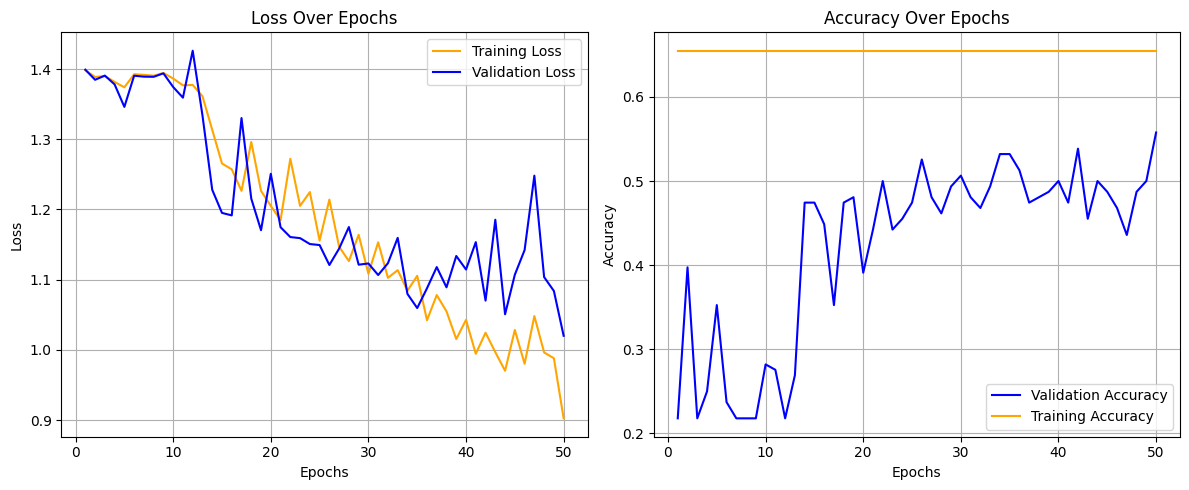

In [47]:
# Plot training & validation loss and accuracy
plt.figure(figsize=(12, 10))

# Loss
plt.subplot(2, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy
plt.subplot(2, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

#SVM With feature extraction using CNN

In [51]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
import os
import numpy as np
from sklearn.model_selection import train_test_split , GridSearchCV
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.applications import VGG16

In [52]:
# Load the pre-trained VGG16 model (without the top classification layers)
base_model_VGG16 = VGG16(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

In [53]:
# Function to extract features using the CNN
def extract_features(dataset):
    features = base_model_VGG16.predict(dataset)
    features = features.reshape(features.shape[0], -1)  # Flatten the features
    return features

In [54]:
# Extract features from training and validation data
X_train_features = extract_features(X_train)
X_val_features = extract_features(X_val)

20/20 ━━━━━━━━━━━━━━━━━━━━ 261s 7s/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 46s 5s/step


In [55]:
# Train SVM classifier
svm_model = make_pipeline(StandardScaler(), SVC(kernel='linear', random_state=42))
svm_model.fit(X_train_features, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(kernel='linear', random_state=42))])

In [56]:
# Predict on training and validation data
y_train_pred = svm_model.predict(X_train_features)
y_val_pred = svm_model.predict(X_val_features)

In [57]:
# Calculate accuracies
train_accuracy = accuracy_score(y_train, y_train_pred)
val_accuracy = accuracy_score(y_val, y_val_pred)

In [58]:
# Print classification report
print("Training Accuracy:", train_accuracy)
print("Validation Accuracy:", val_accuracy)
print(classification_report(y_val, y_val_pred, target_names=categories))

Training Accuracy: 0.9903691813804173
Validation Accuracy: 0.5897435897435898
              precision    recall  f1-score   support

     Level 0       0.63      0.65      0.64        34
     Level 1       0.55      0.64      0.59        44
     Level 2       0.39      0.32      0.35        37
     Level 3       0.77      0.73      0.75        41

    accuracy                           0.59       156
   macro avg       0.58      0.58      0.58       156
weighted avg       0.59      0.59      0.59       156



In [59]:
# Create a simple history dictionary
history = {
    'train_accuracy': [train_accuracy],
    'val_accuracy': [val_accuracy]
}

In [60]:
# Print classification report
print(classification_report(y_val, y_val_pred, target_names=categories))

              precision    recall  f1-score   support

     Level 0       0.63      0.65      0.64        34
     Level 1       0.55      0.64      0.59        44
     Level 2       0.39      0.32      0.35        37
     Level 3       0.77      0.73      0.75        41

    accuracy                           0.59       156
   macro avg       0.58      0.58      0.58       156
weighted avg       0.59      0.59      0.59       156



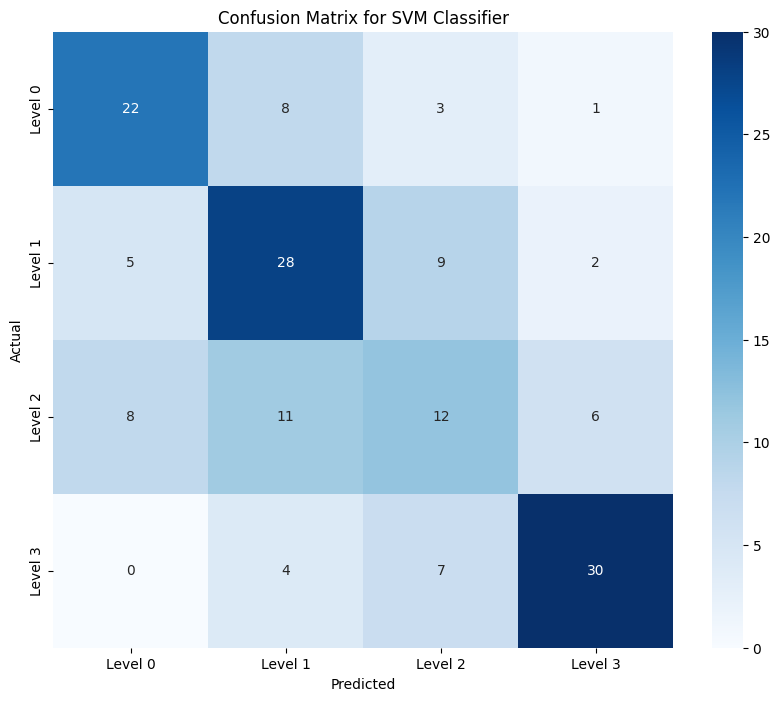

In [61]:
# Show confusion matrix
confusion_mtx = confusion_matrix(y_val, y_val_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix for SVM Classifier')
plt.show()

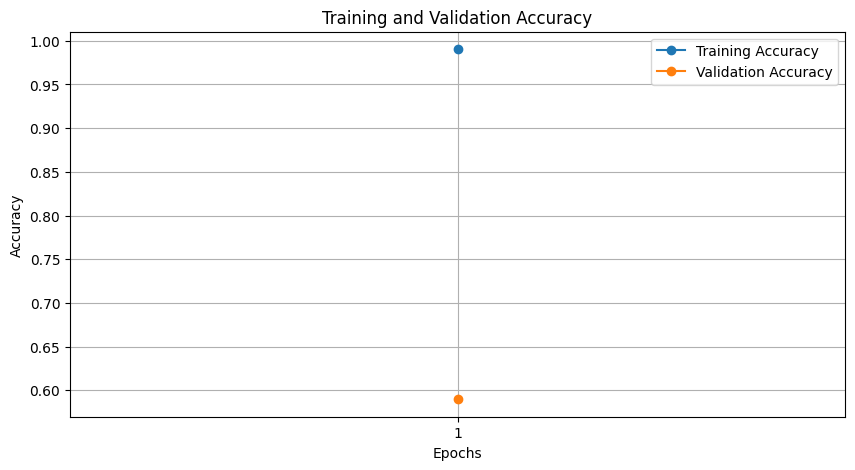

In [62]:
# Plot accuracy
plt.figure(figsize=(10, 5))
plt.plot(history['train_accuracy'], label='Training Accuracy', marker='o')
plt.plot(history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xticks([0], ['1'])  # Only one epoch for SVM
plt.legend()
plt.grid()
plt.show()

In [63]:
import joblib  # For saving the SVM model

In [64]:
# Save the SVM model to a .pkl file using joblib
joblib.dump(svm_model, 'svm_model.pkl')

# Save the VGG16 model as its own .h5 file (if needed)
base_model_VGG16.save('vgg16_Severity_feature_extractor.h5')

#Siamese Network

In [47]:
# Define the base network (shared model)
def create_base_network(input_shape):
    model = Sequential()
    model.add(Conv2D(64, (3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    return model

In [48]:
# Define the Siamese Network
input_shape = (img_height, img_width, 3)
base_network = create_base_network(input_shape)

In [49]:
input_a = Input(shape=input_shape)
input_b = Input(shape=input_shape)

In [50]:
# Encode both inputs
encoded_a = base_network(input_a)
encoded_b = base_network(input_b)

In [51]:
# Calculate the distance between the encodings
def euclidean_distance(vects):
    x, y = vects
    return K.sqrt(K.sum(K.square(x - y), axis=1, keepdims=True))

In [52]:
# Create the Lambda layer to compute distance
distance = Lambda(euclidean_distance)([encoded_a, encoded_b])

# Define the model
siamese_model = Model(inputs=[input_a, input_b], outputs=distance)

# Compile the model
siamese_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

# Display the model summary
siamese_model.summary()

Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_5       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_1        │ (None, 128)       │ 47,851,520 │ input_layer_4[0]… │
│ (Sequential)        │                   │            │ input_layer_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_1 (Lambda)   │ (None, 1)         │          0 │ sequential_1[0][… │
│                     │                   │            │ sequential_1[1][… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 47,851,520 (182.54 MB)

 Trainable params: 47,851,520 (182.54 MB)

 Non-trainable params: 0 (0.00 B)

In [53]:
def create_pairs(images, labels):
    pairs = []
    labels_out = []
    num_classes = len(np.unique(labels))
    
    for category in range(num_classes):
        # Get all indices of the current category
        category_indices = np.where(labels == category)[0]
        
        if len(category_indices) < 2:
            continue  # Not enough images to create pairs
        
        for i in range(len(category_indices)):
            # Positive pair
            z1 = images[category_indices[i]]
            z2 = images[np.random.choice(category_indices)]
            pairs.append([z1, z2])
            labels_out.append(1)  # Same class
            
            # Negative pair
            z1 = images[category_indices[i]]
            # Ensure we select an image from a different category
            z2 = images[np.random.choice(np.setdiff1d(np.arange(len(labels)), category_indices))]
            pairs.append([z1, z2])
            labels_out.append(0)  # Different class

    return np.array(pairs), np.array(labels_out)

In [54]:
# Create pairs and labels
pairs, pair_labels = create_pairs(images, labels)

# Debug: Check the shape of pairs and pair_labels
print(f"Number of pairs: {len(pairs)}, Number of labels: {len(pair_labels)}")

# Check if pairs are successfully created
if len(pairs) > 0:
    # Split pairs into training and validation sets
    X_train_pairs, X_val_pairs, y_train_pairs, y_val_pairs = train_test_split(pairs, pair_labels, test_size=0.2, random_state=42)
else:
    print("No pairs were created. Check the data.")

Number of pairs: 64, Number of labels: 64


In [59]:
history = siamese_model.fit(
    [X_train_pairs[:, 0], X_train_pairs[:, 1]],
    y_train_pairs,
    validation_data=([X_val_pairs[:, 0], X_val_pairs[:, 1]], y_val_pairs),
    epochs=100,
    batch_size=32
).history

Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 4s/step - accuracy: 0.5535 - loss: 0.4465 - val_accuracy: 0.3077 - val_loss: 0.6923
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 3s/step - accuracy: 0.5431 - loss: 0.4569 - val_accuracy: 0.3077 - val_loss: 0.6923
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 3s/step - accuracy: 0.5639 - loss: 0.4361 - val_accuracy: 0.3077 - val_loss: 0.6923
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 4s/step - accuracy: 0.5431 - loss: 0.4569 - val_accuracy: 0.3077 - val_loss: 0.6923
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 4s/step - accuracy: 0.5118 - loss: 0.4882 - val_accuracy: 0.3077 - val_loss: 0.6923
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.5327 - loss: 0.4673 - val_accuracy: 0.3077 - val_loss: 0.6923
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.5743 - loss: 0.4257 - val_accuracy: 0.3077 - val_loss: 0.6923
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.5535 - loss: 0.4465 - val_accuracy: 0.3077 - val_loss: 0.6923
Epoch 9/

In [57]:
# # Evaluate the model
# val_loss = siamese_model.evaluate([X_val_pairs[:, 0], X_val_pairs[:, 1]], y_val_pairs)
# print(f'Validation Loss: {val_loss}')

# # Predictions
# predictions = siamese_model.predict([X_val_pairs[:, 0], X_val_pairs[:, 1]])
# predicted_labels = (predictions > 0.5).astype(int)  # Assuming a threshold of 0.5

# # Calculate accuracy
# accuracy = np.mean(predicted_labels.flatten() == y_val_pairs)
# print(f'Validation Accuracy: {accuracy * 100:.2f}%')

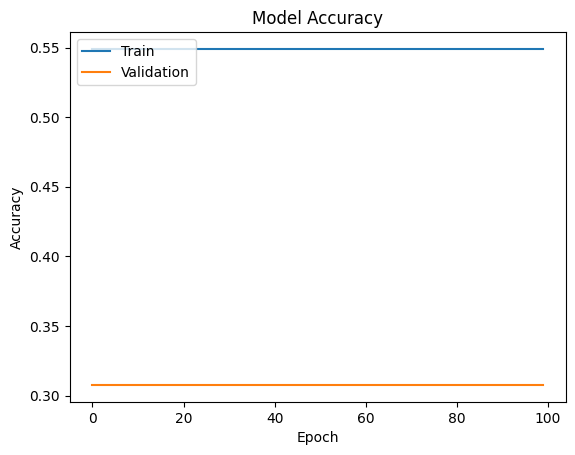

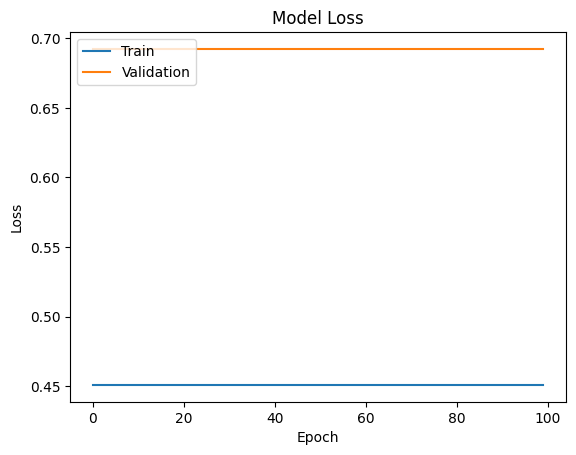

In [60]:
# Plot the training and validation accuracy
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot the training and validation loss
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

#CNN Model

In [76]:
# Create EfficientNetB0 model
def create_model():
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
    base_model.trainable = False  # Freeze the base model

    model = Sequential([
        base_model,
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(len(categories), activation='softmax')
    ])
    
    return model

In [77]:
# Create and compile the model
model = create_model()
model.compile(optimizer=Adam(), loss=SparseCategoricalCrossentropy(), metrics=['accuracy'])


In [78]:
# Class weights to handle class imbalance
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = {i: class_weights[i] for i in range(len(class_weights))}


In [82]:
def scheduler(epoch, lr):
    if epoch > 10:
        lr = float(lr * tf.math.exp(-0.1))
    return lr

lr_scheduler = LearningRateScheduler(scheduler)

In [83]:
# Set up early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


In [85]:
# Train the model
history = model.fit(
    train_dataset, 
    validation_data=val_dataset, 
    epochs=50, 
    callbacks=[early_stopping, lr_scheduler],
    class_weight=class_weights
)

Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.2509 - loss: 1.3852 - val_accuracy: 0.2372 - val_loss: 1.3863 - learning_rate: 0.0010
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.2553 - loss: 1.3837 - val_accuracy: 0.2372 - val_loss: 1.3863 - learning_rate: 0.0010
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.2432 - loss: 1.3853 - val_accuracy: 0.2372 - val_loss: 1.3862 - learning_rate: 0.0010
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.2437 - loss: 1.3837 - val_accuracy: 0.2372 - val_loss: 1.3863 - learning_rate: 0.0010
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.2480 - loss: 1.3868 - val_accuracy: 0.2372 - val_loss: 1.3863 - learning_rate: 0.0010
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.2482 - loss: 1.3843 - val_accuracy: 0.2372 - val_loss: 1.3863 - learning_rate: 0.0010
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.2363 - loss: 1.3905 - val_accuracy: 

In [86]:
# Evaluate the model
val_loss, val_accuracy = model.evaluate(val_dataset)
print(f'Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}')

5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 736ms/step - accuracy: 0.2475 - loss: 1.3861
Validation Loss: 1.3861521482467651, Validation Accuracy: 0.2371794879436493


4/5 ━━━━━━━━━━━━━━━━━━━━ 0s 750ms/stepWARNING:tensorflow:5 out of the last 16 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x000001CCE0021EE0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


5/5 ━━━━━━━━━━━━━━━━━━━━ 104s 2s/step


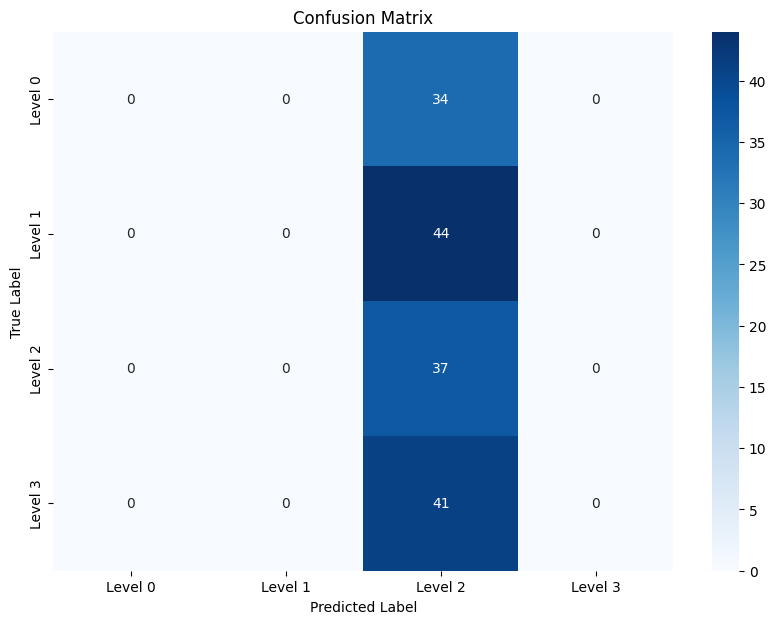

In [87]:
# Generate predictions
y_pred = model.predict(val_dataset)
y_pred_classes = np.argmax(y_pred, axis=1)

# Confusion Matrix
conf_matrix = confusion_matrix(y_val, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [88]:
# Classification Report
print(classification_report(y_val, y_pred_classes, target_names=categories))


              precision    recall  f1-score   support

     Level 0       0.00      0.00      0.00        34
     Level 1       0.00      0.00      0.00        44
     Level 2       0.24      1.00      0.38        37
     Level 3       0.00      0.00      0.00        41

    accuracy                           0.24       156
   macro avg       0.06      0.25      0.10       156
weighted avg       0.06      0.24      0.09       156



e:\sliit\Year 4\Research Project\DEMO\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
e:\sliit\Year 4\Research Project\DEMO\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
e:\sliit\Year 4\Research Project\DEMO\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

In [89]:
# Save the model
model.save('acne_severity_effitientNet_model.h5')
print("Model saved as 'acne_severity_effitientNet_model.h5'.")

# Save training history
history_dict = history.history
with open('acne_severity_effitientNet_training_history.json', 'w') as f:
    json.dump(history_dict, f)
print("Training history saved as 'acne_severity_effitientNet_training_history.json'.")

Model saved as 'acne_severity_effitientNet_model.h5'.
Training history saved as 'acne_severity_effitientNet_training_history.json'.


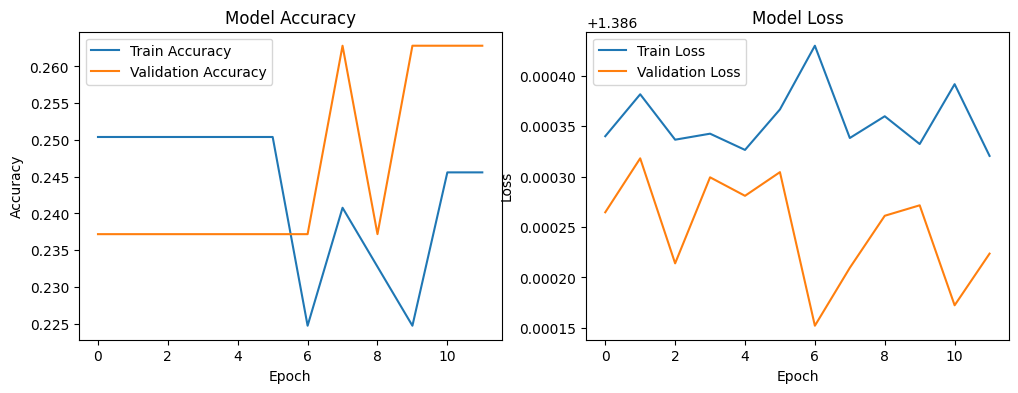

In [90]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

#RestNet 50 , 101 , 152

In [100]:
from tensorflow.keras.applications import ResNet50, ResNet101, ResNet152
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

In [101]:
# Function to build and compile models
def build_model(model_name):
    if model_name == 'ResNet50':
        base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
    elif model_name == 'ResNet101':
        base_model = ResNet101(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
    elif model_name == 'ResNet152':
        base_model = ResNet152(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

    for layer in base_model.layers:
        layer.trainable = False  # Freeze the base model layers

    model = Sequential([
        base_model,
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(len(categories), activation='softmax')
    ])

    model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [102]:
# Function to plot training history
def plot_history(history, model_name):
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name} Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

In [104]:
# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
    plt.title(f'{model_name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

In [105]:
# Train and evaluate models
models = ['ResNet50', 'ResNet101', 'ResNet152']
best_model_restnet = None
best_accuracy = 0

Training ResNet50...
Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 142s 5s/step - accuracy: 0.2563 - loss: 10.8469 - val_accuracy: 0.2821 - val_loss: 1.3844
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 60s 3s/step - accuracy: 0.2539 - loss: 1.3986 - val_accuracy: 0.2179 - val_loss: 1.3863
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 54s 3s/step - accuracy: 0.2638 - loss: 1.3862 - val_accuracy: 0.2179 - val_loss: 1.3865
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 56s 3s/step - accuracy: 0.2620 - loss: 1.3862 - val_accuracy: 0.2179 - val_loss: 1.3867
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 55s 3s/step - accuracy: 0.2513 - loss: 1.3863 - val_accuracy: 0.2179 - val_loss: 1.3868
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 54s 3s/step - accuracy: 0.2714 - loss: 1.3860 - val_accuracy: 0.2179 - val_loss: 1.3870
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 52s 3s/step - accuracy: 0.2580 - loss: 1.3860 - val_accuracy: 0.2179 - val_loss: 1.3871
Epoch 8/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 55s 3s/step - accuracy: 0.2842 - loss: 1.3858 - val_accur

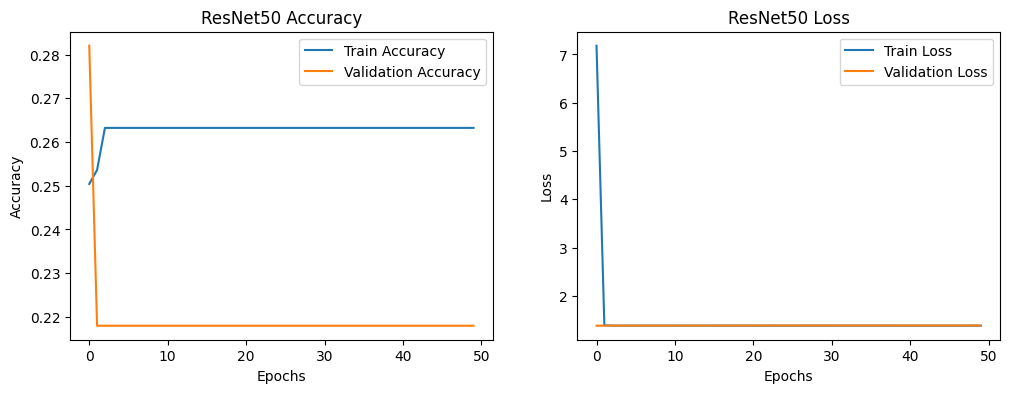

5/5 ━━━━━━━━━━━━━━━━━━━━ 43s 4s/step


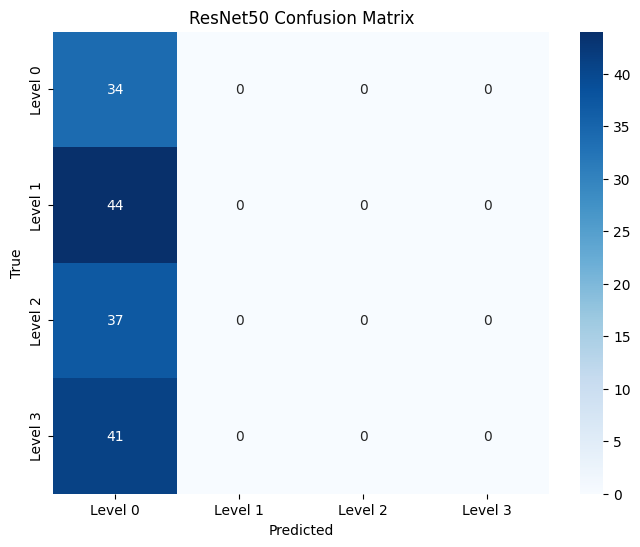

Training ResNet101...
171446536/171446536 ━━━━━━━━━━━━━━━━━━━━ 43s 0us/step
Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 209s 9s/step - accuracy: 0.2518 - loss: 10.2689 - val_accuracy: 0.2628 - val_loss: 1.3754
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 95s 5s/step - accuracy: 0.2212 - loss: 1.4570 - val_accuracy: 0.2308 - val_loss: 1.3864
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 96s 5s/step - accuracy: 0.2346 - loss: 1.3863 - val_accuracy: 0.2308 - val_loss: 1.3865
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 95s 5s/step - accuracy: 0.2440 - loss: 1.3858 - val_accuracy: 0.2308 - val_loss: 1.3867
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 96s 5s/step - accuracy: 0.2365 - loss: 1.3862 - val_accuracy: 0.2179 - val_loss: 1.3868
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 90s 4s/step - accuracy: 0.2665 - loss: 1.3849 - val_accuracy: 0.2179 - val_loss: 1.3870
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 137s 7s/step - accuracy: 0.2412 - loss: 1.3865 - val_accuracy: 0.2179 - val_loss: 1.3871
Epoch 8/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 8

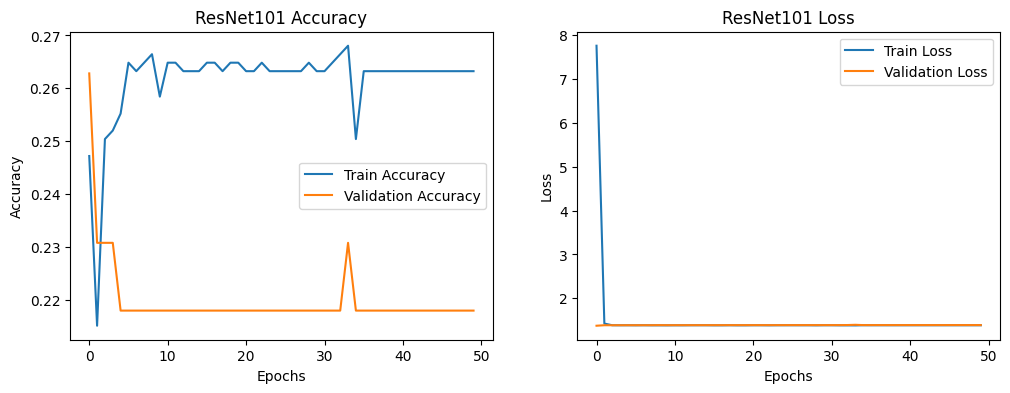

5/5 ━━━━━━━━━━━━━━━━━━━━ 42s 5s/step


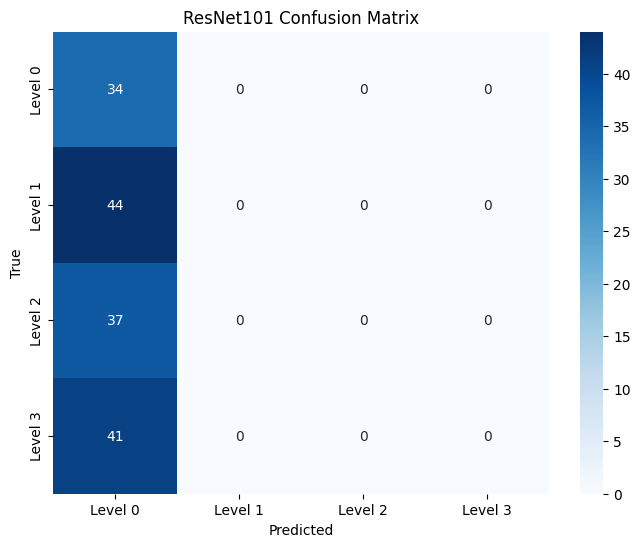

Training ResNet152...
234698864/234698864 ━━━━━━━━━━━━━━━━━━━━ 145s 1us/step
Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 234s 10s/step - accuracy: 0.2514 - loss: 8.8760 - val_accuracy: 0.2308 - val_loss: 1.3864
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 176s 9s/step - accuracy: 0.2954 - loss: 1.3919 - val_accuracy: 0.2308 - val_loss: 1.3865
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 173s 9s/step - accuracy: 0.2282 - loss: 1.3863 - val_accuracy: 0.2179 - val_loss: 1.3866
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 111s 6s/step - accuracy: 0.2397 - loss: 1.3863 - val_accuracy: 0.2179 - val_loss: 1.3867
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 172s 9s/step - accuracy: 0.2608 - loss: 1.3863 - val_accuracy: 0.2179 - val_loss: 1.3869
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 173s 9s/step - accuracy: 0.2705 - loss: 1.3863 - val_accuracy: 0.2179 - val_loss: 1.3869
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 172s 9s/step - accuracy: 0.2779 - loss: 1.3859 - val_accuracy: 0.2179 - val_loss: 1.3872
Epoch 8/50
20/20 ━━━━━━━━━━━━━━━━

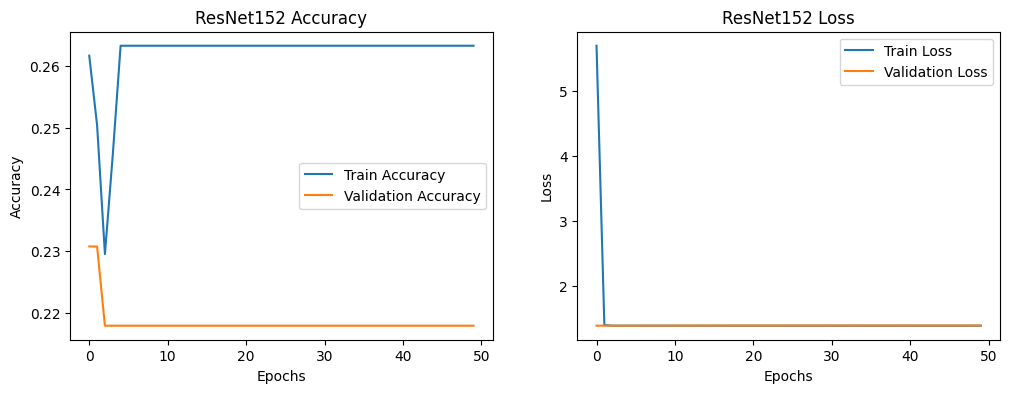

5/5 ━━━━━━━━━━━━━━━━━━━━ 208s 49s/step


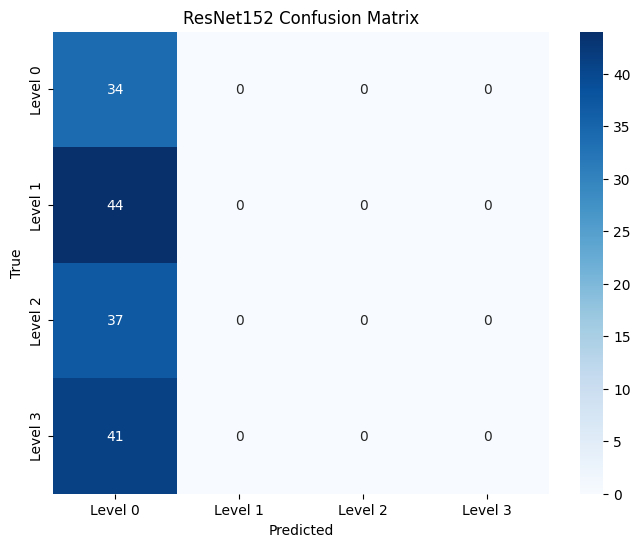

Best model: sequential_5 with accuracy: 0.2179


In [107]:
for model_name in models:
    print(f"Training {model_name}...")
    model = build_model(model_name)
    history = model.fit(train_dataset, validation_data=val_dataset, epochs=50)  # Adjust epochs as needed

    # Evaluate the model
    val_loss, val_accuracy = model.evaluate(val_dataset)
    print(f"{model_name} Validation Accuracy: {val_accuracy:.4f}")

    # Plot training history
    plot_history(history, model_name)

    # Make predictions and plot confusion matrix
    y_pred = model.predict(X_val)
    y_pred_classes = np.argmax(y_pred, axis=1)

    plot_confusion_matrix(y_val, y_pred_classes, model_name)

    # Check if this is the best model
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        best_model_restnet = model

print(f"Best model: {best_model_restnet.name} with accuracy: {best_accuracy:.4f}")

#VGG16

In [122]:
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications import VGG19

In [123]:
# Load VGG19 model
base_model_VGG19 = VGG19(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

In [124]:
# Unfreeze the last few layers of the base model
for layer in base_model_VGG19.layers[:-4]:  # Unfreeze the last 4 layers
    layer.trainable = True

In [125]:
# Create the model
model_VGG19 = Sequential([
    base_model_VGG19,
    GlobalAveragePooling2D(),  # Global Average Pooling to reduce overfitting
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(len(categories), activation='softmax')  # Number of classes
])

In [126]:
# Compile the model
model_VGG19.compile(optimizer=Adam(learning_rate=1e-4),  # Adjust learning rate
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [127]:
# Define early stopping and learning rate reduction
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)


In [128]:
# Train the model
history = model_VGG19.fit(datagen.flow(X_train, y_train, batch_size=batch_size),
                    validation_data=(X_val, y_val),
                    epochs=50,
                    callbacks=[early_stopping, reduce_lr])

e:\sliit\Year 4\Research Project\DEMO\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1317s 60s/step - accuracy: 0.2840 - loss: 1.4933 - val_accuracy: 0.2179 - val_loss: 1.3867 - learning_rate: 1.0000e-04
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 427s 21s/step - accuracy: 0.2212 - loss: 1.3901 - val_accuracy: 0.2179 - val_loss: 1.3890 - learning_rate: 1.0000e-04
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 422s 21s/step - accuracy: 0.2931 - loss: 1.3872 - val_accuracy: 0.2244 - val_loss: 1.3860 - learning_rate: 1.0000e-04
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 413s 21s/step - accuracy: 0.2500 - loss: 1.3860 - val_accuracy: 0.2179 - val_loss: 1.3855 - learning_rate: 1.0000e-04
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 443s 22s/step - accuracy: 0.2501 - loss: 1.3854 - val_accuracy: 0.2179 - val_loss: 1.3851 - learning_rate: 1.0000e-04
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 450s 22s/step - accuracy: 0.2767 - loss: 1.3849 - val_accuracy: 0.2179 - val_loss: 1.3839 - learning_rate: 1.0000e-04
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 445s 22s/step - accuracy:

In [129]:
# Save the model
model_VGG19.save('acne_severity_classification_model_VGG16.h5')
print("Model saved as 'acne_severity_classification_model_VGG16.h5'.")

Model saved as 'acne_severity_classification_model_VGG16.h5'.


In [130]:
# Evaluate the model
val_loss, val_accuracy = model_VGG19.evaluate(X_val, y_val)
print(f'Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}')


5/5 ━━━━━━━━━━━━━━━━━━━━ 28s 5s/step - accuracy: 0.2315 - loss: 1.3600
Validation Loss: 1.3570374250411987, Validation Accuracy: 0.21794871985912323


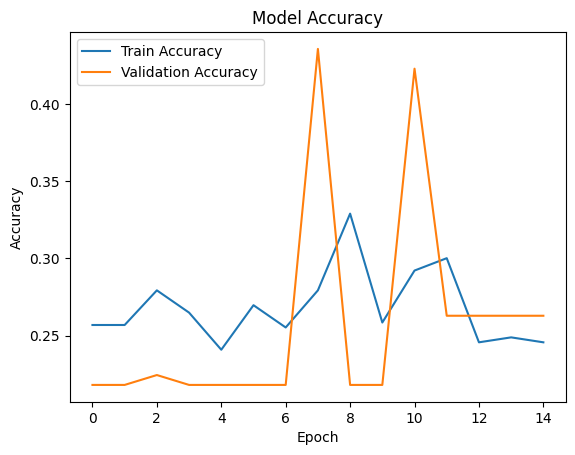

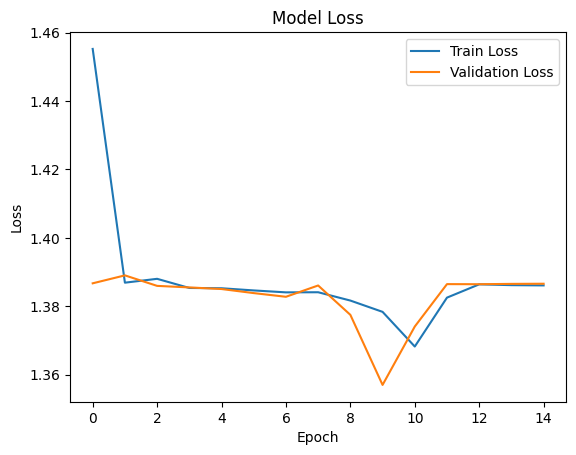

In [131]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

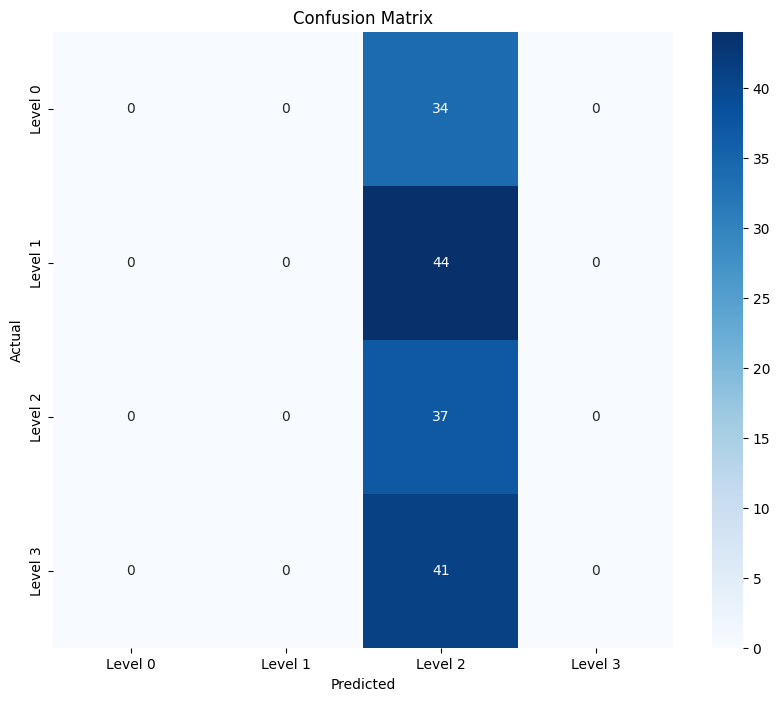

e:\sliit\Year 4\Research Project\DEMO\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
e:\sliit\Year 4\Research Project\DEMO\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

     Level 0       0.22      1.00      0.36        34
     Level 1       0.00      0.00      0.00        44
     Level 2       0.00      0.00      0.00        37
     Level 3       0.00      0.00      0.00        41

    accuracy                           0.22       156
   macro avg       0.05      0.25      0.09       156
weighted avg       0.05      0.22      0.08       156



e:\sliit\Year 4\Research Project\DEMO\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [132]:
# Plotting the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print(classification_report(y_val, y_pred_classes, target_names=categories))

#VGG16

In [133]:
# Load VGG16 model
base_model_VGG16 = VGG16(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

In [134]:
# Unfreeze the last layers of the base model
for layer in base_model_VGG16.layers[-4:]:  # Unfreeze the last 4 layers
    layer.trainable = True

In [135]:
# Create the model
model_VGG16 = Sequential([
    base_model_VGG16,
    GlobalAveragePooling2D(),  # Global Average Pooling to reduce overfitting
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(len(categories), activation='softmax')  # Number of classes
])

In [143]:
# Compile the model
model_VGG16.compile(optimizer=Adam(learning_rate=1e-5),  # Adjust learning rate
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [144]:
# Define early stopping and learning rate reduction
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)


In [145]:
# Train the model
history = model_VGG16.fit(datagen.flow(X_train, y_train, batch_size=batch_size),
                    validation_data=(X_val, y_val),
                    epochs=50,
                    callbacks=[early_stopping, reduce_lr])

e:\sliit\Year 4\Research Project\DEMO\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 868s 21s/step - accuracy: 0.2467 - loss: 1.3869 - val_accuracy: 0.2179 - val_loss: 1.3861 - learning_rate: 1.0000e-05
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 351s 18s/step - accuracy: 0.2636 - loss: 1.3853 - val_accuracy: 0.2179 - val_loss: 1.3843 - learning_rate: 1.0000e-05
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 377s 19s/step - accuracy: 0.2741 - loss: 1.3829 - val_accuracy: 0.2244 - val_loss: 1.3810 - learning_rate: 1.0000e-05
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 370s 19s/step - accuracy: 0.2770 - loss: 1.3802 - val_accuracy: 0.2179 - val_loss: 1.3778 - learning_rate: 1.0000e-05
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 398s 20s/step - accuracy: 0.2559 - loss: 1.3779 - val_accuracy: 0.3397 - val_loss: 1.3600 - learning_rate: 1.0000e-05
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 337s 17s/step - accuracy: 0.3175 - loss: 1.3559 - val_accuracy: 0.4295 - val_loss: 1.3549 - learning_rate: 1.0000e-05
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 326s 16s/step - accuracy: 

In [146]:
# Save the model
model_VGG16.save('acne_severity_classification_model_vgg16.h5')
print("Model saved as 'acne_severity_classification_model_vgg16.h5'.")

# Evaluate the model
val_loss, val_accuracy = model_VGG16.evaluate(X_val, y_val)
print(f'Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}')


Model saved as 'acne_severity_classification_model_vgg16.h5'.
5/5 ━━━━━━━━━━━━━━━━━━━━ 21s 4s/step - accuracy: 0.6483 - loss: 0.8702
Validation Loss: 0.9062918424606323, Validation Accuracy: 0.6025640964508057


In [147]:
# Get predictions
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)

5/5 ━━━━━━━━━━━━━━━━━━━━ 51s 5s/step


In [148]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_val, y_pred_classes)


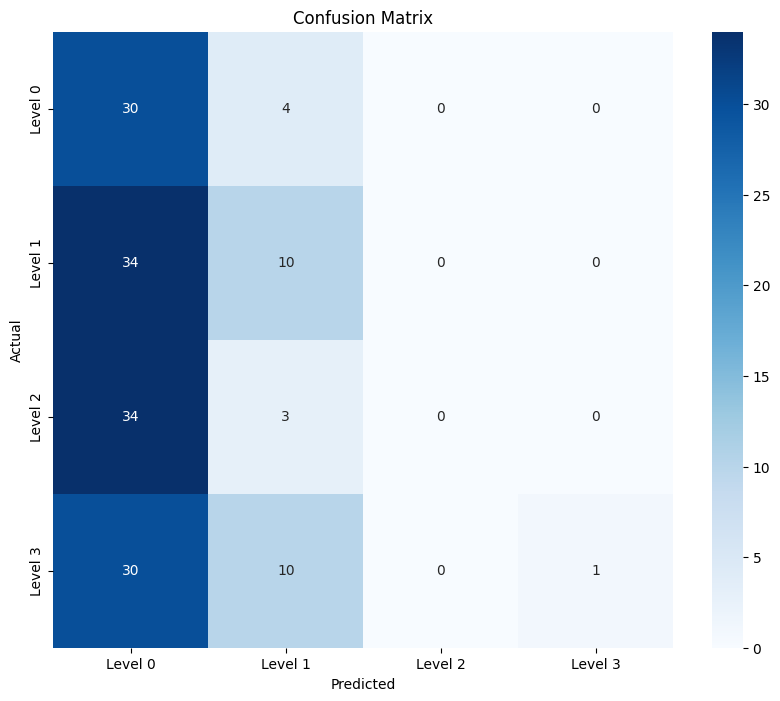

e:\sliit\Year 4\Research Project\DEMO\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

     Level 0       0.23      0.88      0.37        34
     Level 1       0.37      0.23      0.28        44
     Level 2       0.00      0.00      0.00        37
     Level 3       1.00      0.02      0.05        41

    accuracy                           0.26       156
   macro avg       0.40      0.28      0.17       156
weighted avg       0.42      0.26      0.17       156



e:\sliit\Year 4\Research Project\DEMO\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
e:\sliit\Year 4\Research Project\DEMO\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [149]:
# Plotting the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print(classification_report(y_val, y_pred_classes, target_names=categories))

#DCNN

In [71]:
# Load pre-trained ResNet50 model
base_model_dcnn = ResNet50(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

#  Fine-tune the later layers of the base model
for layer in base_model_dcnn.layers[-10:]:  # Unfreeze the last 10 layers
    layer.trainable = True 

In [72]:
# Create DCNN model
model_dcnn = Sequential([
    base_model_dcnn,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(4,activation='softmax')
])

In [73]:
# Compile the DCNN model
model_dcnn.compile(optimizer=Adam(learning_rate=0.0001),
              loss='SparseCategoricalCrossentropy',
              metrics=['accuracy'])

In [74]:
# Train the DCNN model
epochs_dcnn = 16
history_dcnn = model_dcnn.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs_dcnn,
    class_weight=class_weights_dict
)


Epoch 1/16
20/20 ━━━━━━━━━━━━━━━━━━━━ 369s 13s/step - accuracy: 0.4160 - loss: 1.3753 - val_accuracy: 0.2628 - val_loss: 1.7945
Epoch 2/16
20/20 ━━━━━━━━━━━━━━━━━━━━ 242s 12s/step - accuracy: 0.8666 - loss: 0.4295 - val_accuracy: 0.2628 - val_loss: 1.4274
Epoch 3/16
20/20 ━━━━━━━━━━━━━━━━━━━━ 232s 12s/step - accuracy: 0.9673 - loss: 0.1637 - val_accuracy: 0.2628 - val_loss: 1.4463
Epoch 4/16
20/20 ━━━━━━━━━━━━━━━━━━━━ 240s 12s/step - accuracy: 0.9734 - loss: 0.0851 - val_accuracy: 0.2821 - val_loss: 1.5665
Epoch 5/16
20/20 ━━━━━━━━━━━━━━━━━━━━ 238s 12s/step - accuracy: 0.9852 - loss: 0.0625 - val_accuracy: 0.2821 - val_loss: 1.5909
Epoch 6/16
20/20 ━━━━━━━━━━━━━━━━━━━━ 239s 12s/step - accuracy: 0.9919 - loss: 0.0361 - val_accuracy: 0.2821 - val_loss: 1.6784
Epoch 7/16
20/20 ━━━━━━━━━━━━━━━━━━━━ 240s 12s/step - accuracy: 0.9896 - loss: 0.0317 - val_accuracy: 0.2821 - val_loss: 1.7422
Epoch 8/16
20/20 ━━━━━━━━━━━━━━━━━━━━ 243s 12s/step - accuracy: 0.9901 - loss: 0.0261 - val_accuracy: 0.

In [75]:
#recording history
with open('history_dcnn_acne_severity.json', 'w') as f:
    json.dump(history_dcnn.history, f)

##ResNet

In [76]:
def build_enhanced_resnet(input_shape, num_classes):
    base_model_resnet = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model_resnet.trainable = False  # Freeze the base model layers

    model = Sequential([
        base_model_resnet,
        Conv2D(512, (3, 3), activation='relu', padding='same'),  # Add a convolutional layer
        BatchNormalization(),                                  # Add Batch Normalization
        MaxPooling2D((2, 2)),                                 # Add Max Pooling
        Flatten(),
        Dense(256, activation='relu'),                         # Add a dense layer
        Dropout(0.5),                                          # Add Dropout for regularization
        Dense(num_classes, activation='softmax')              # Output layer
    ])

    return model

In [78]:
# Build the enhanced ResNet model
model_resnet_enhanced = build_enhanced_resnet(input_shape=(224, 224, 3), num_classes=4)


In [82]:
model_resnet_enhanced.compile(optimizer=Adam(), loss='SparseCategoricalCrossentropy', metrics=['accuracy'])

In [83]:
model_resnet_enhanced.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 7, 7, 512)      │     9,437,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 7, 7, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,208,388 (130.49 MB)

 Trainable params: 10,619,652 (40.51 MB)

 Non-trainable params: 23,588,736 (89.98 MB)

In [81]:
epochs_resnet_enhanced = 100
history_resnet_enhanced = model_resnet_enhanced.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs_resnet_enhanced
)

Epoch 1/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 103s 5s/step - accuracy: 0.2414 - loss: 6.3951 - val_accuracy: 0.2372 - val_loss: 5.0991
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 70s 4s/step - accuracy: 0.2605 - loss: 1.5144 - val_accuracy: 0.2821 - val_loss: 1.4196
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 59s 3s/step - accuracy: 0.2881 - loss: 1.3879 - val_accuracy: 0.2821 - val_loss: 1.3830
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 58s 3s/step - accuracy: 0.2488 - loss: 1.3865 - val_accuracy: 0.2821 - val_loss: 1.3825
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 57s 3s/step - accuracy: 0.2827 - loss: 1.3861 - val_accuracy: 0.2821 - val_loss: 1.3838
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 56s 3s/step - accuracy: 0.2561 - loss: 1.3863 - val_accuracy: 0.2821 - val_loss: 1.3844
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 56s 3s/step - accuracy: 0.2812 - loss: 1.3861 - val_accuracy: 0.2821 - val_loss: 1.3849
Epoch 8/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 58s 3s/step - accuracy: 0.3013 - loss: 1.3857 - val_accuracy: 0.2821 - 

In [ ]:
#Recording History
with open('history_resnet_enhanced.json', 'w') as f:
    json.dump(history_resnet_enhanced.history, f)

In [ ]:
# Choose the best model based on performance (e.g., validation accuracy)
best_model = model_cnn
if history_dcnn.history['val_accuracy'][-1] > history_cnn.history['val_accuracy'][-1]:
    best_model = model_dcnn
if history_resnet_enhanced.history['val_accuracy'][-1] > history_dcnn.history['val_accuracy'][-1] and history_resnet_enhanced.history['val_accuracy'][-1] > history_cnn.history['val_accuracy'][-1]:
    best_model = model_resnet_enhanced

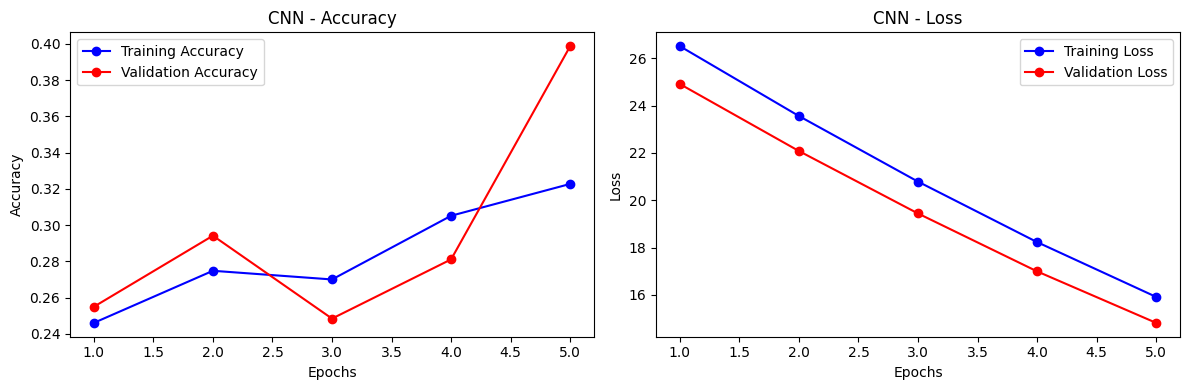

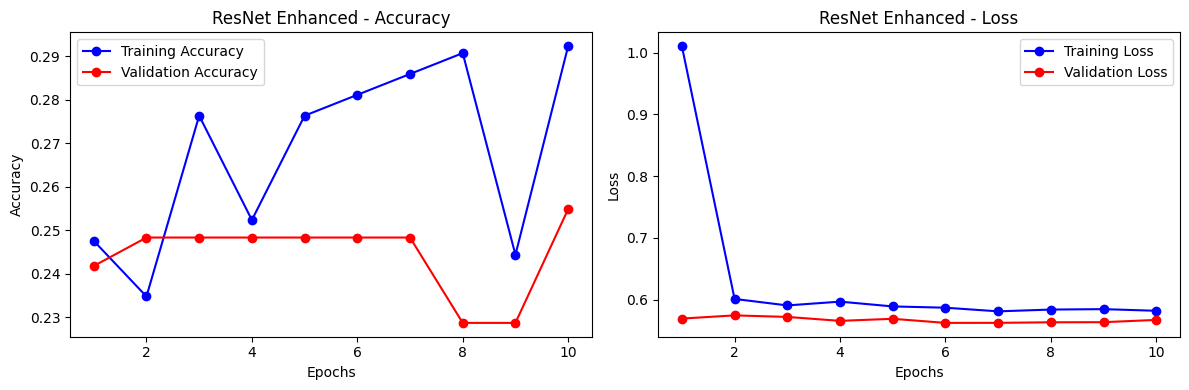

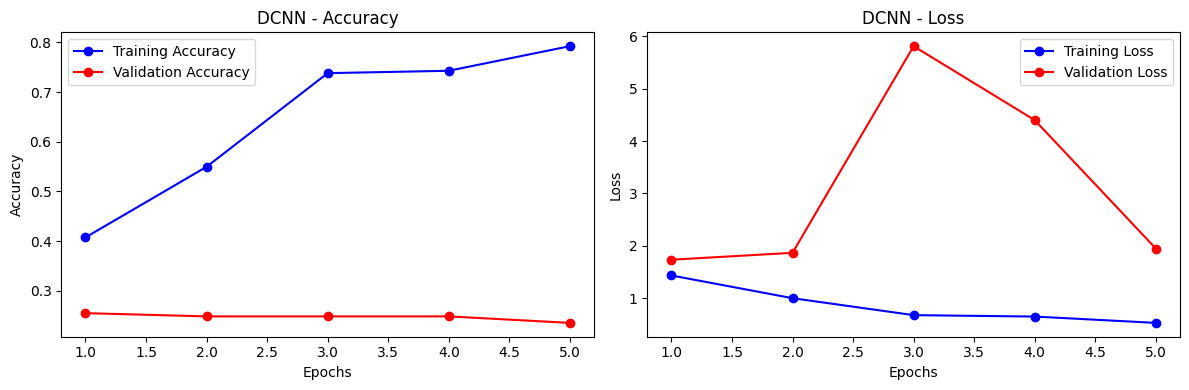

In [ ]:
def plot_accuracy_and_loss(history, model_name):
    """Plots the training and validation accuracy and loss curves."""

    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo-', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
    plt.title(f'{model_name} - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo-', label='Training Loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
    plt.title(f'{model_name} - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot accuracy and loss for each model
plot_accuracy_and_loss(history_cnn, "CNN")
plot_accuracy_and_loss(history_resnet_enhanced, "ResNet Enhanced")
plot_accuracy_and_loss(history_dcnn, "DCNN")

Shape of first_image: (128, 128, 3)
Data type of first_image: float32
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


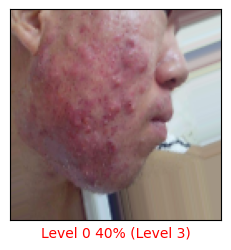

Actual label: Level 3
Predicted label: Level 0


In [ ]:
images_batch, labels_batch = next(val_ds)

first_image = images_batch[0]
first_label = labels_batch[0]  # This will be a one-hot encoded vector

print("Shape of first_image:", first_image.shape)
print("Data type of first_image:", first_image.dtype)

# Make prediction (ensure the input is in the correct format)
prediction = best_model.predict(np.expand_dims(first_image, axis=0))

# Get predicted class index
predicted_class_index = (prediction > 0.5).astype("int32")[0][0]  # Adjust for binary classification


# Get actual class index (since you're using multi-class classification with one-hot encoding)
actual_class_index = np.argmax(first_label)  # Get index of the maximum value (1 in this case)

# Function to plot image with prediction and true label
def plot_image(prediction, true_label, img):
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img)  # No need for cmap=plt.cm.binary for color images

    predicted_label = (prediction > 0.5).astype("int32")[0][0]  # Adjust for binary classification
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'

    class_names_list = list(class_names.keys())  # Get class names

    plt.xlabel("{} {:2.0f}% ({})".format(class_names_list[predicted_label],
                                         100*np.max(prediction),
                                         class_names_list[true_label]),
               color=color)

plt.figure(figsize=(6, 3))
plt.subplot(1, 2, 1)
plot_image(prediction, actual_class_index, first_image)
plt.show()

# Print actual and predicted labels
class_names_list = list(class_names.keys())  # Get class names
print("Actual label:", class_names_list[actual_class_index])
print("Predicted label:", class_names_list[predicted_class_index])

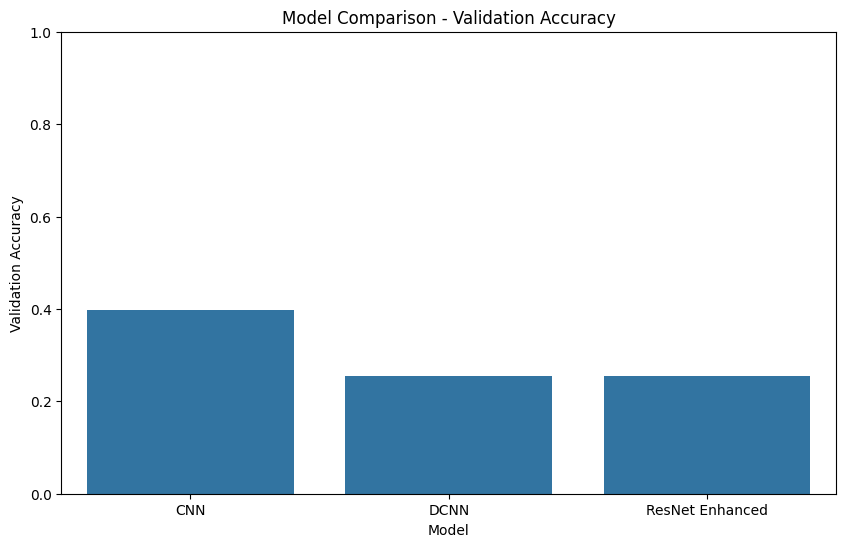

             Model  Validation Accuracy
0              CNN             0.398693
1             DCNN             0.254902
2  ResNet Enhanced             0.254902


In [ ]:
# Extract accuracy values from history objects
histories = [history_cnn, history_dcnn, history_resnet_enhanced]  # Update with your models
model_names = ["CNN", "DCNN", "ResNet Enhanced"]  # Update with your model names
val_accuracies = [max(history.history['val_accuracy']) for history in histories]

# Create a DataFrame
df = pd.DataFrame({"Model": model_names, "Validation Accuracy": val_accuracies})

# Sort the DataFrame by accuracy in descending order
df = df.sort_values(by="Validation Accuracy", ascending=False)

# Plot the accuracies
plt.figure(figsize=(10, 6))
sns.barplot(x="Model", y="Validation Accuracy", data=df)
plt.title("Model Comparison - Validation Accuracy")
plt.xlabel("Model")
plt.ylabel("Validation Accuracy")
plt.ylim(0, 1)  # Set y-axis limits for better visualization
plt.show()

# Print the sorted DataFrame
print(df)

In [ ]:
# 1. Predictions on the validation set
y_pred_prob = best_model.predict(val_ds)  # Get predicted probabilities
y_pred = np.argmax(y_pred_prob, axis=1)

5/5 ━━━━━━━━━━━━━━━━━━━━ 21s 3s/step


In [ ]:
# 2. True labels for the validation set
y_true = val_ds.classes  # Get the true class labels

In [ ]:
print(classification_report(y_true,y_pred, target_names=class_names))

              precision    recall  f1-score   support

     Level 0       0.00      0.00      0.00        77
     Level 1       0.46      1.00      0.63       123
     Level 2       0.00      0.00      0.00        38
     Level 3       0.00      0.00      0.00        29

    accuracy                           0.46       267
   macro avg       0.12      0.25      0.16       267
weighted avg       0.21      0.46      0.29       267



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
cm = confusion_matrix(y_true, y_pred)

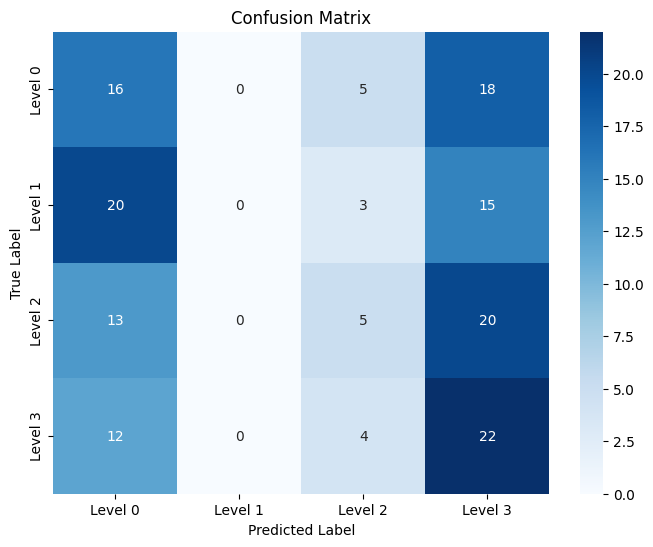

In [ ]:
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names,yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
# save the model using dill
with open('acne_severity_detection_model.pkl', 'wb') as f:
    dill.dump(model_cnn, f)

# Load the model using dill
with open('acne_severity_detection_model.pkl', 'rb') as f:
    model_cnn = dill.load(f)


In [ ]:
model_cnn.save('acne_severity_detection_model.h5')